In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys
import torch

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *

In [104]:
def process_data(hdf5file, test:bool = False):

    data = h5py.File(hdf5file, "r")
    #print(data.keys())
    x_labels = ["x1", "x2"]
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["xvalues"][:, i]).flatten()

    df["Confidence"] = data["confidence"]
    df["Predicted_color"] = "red"
    df_copy = df.copy()
    mask = df_copy["Confidence"] >= 0.5
    df.loc[mask, "Predicted_color"] = "green"


    # Get truth label values (annoying because text is not read as text, should fix)
    if (test == False):
        df["Truth_value"] = data["truth"]
        green = df["Truth_value"][len(df)-1]
        df["Truth"] = "red"
        df["Truth_int"] = 0
        #df["Truth"][df["Truth_value"] == green] = "green"
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == green
        df.loc[mask, "Truth"] = "green"
        df.loc[mask, "Truth_int"] = 1
    
    # Get estimated probabilities
    df["red"] = data["probabilities"][:,0]
    df["green"] = data["probabilities"][:,1]
    df["P(green|x)"] = data["probabilities"][:,1]

    # Get inferred color
    df["Inferred_color"] = df[['red','green']].idxmax(axis=1)

    # Get error bars
    df["quantile25_red"] = data["quantiles"][:, 1, 0]
    df["quantile75_red"] = data["quantiles"][:, 2, 0]
    df["quantile25_green"] = data["quantiles"][:, 1, 1]
    df["quantile75_green"] = data["quantiles"][:, 2, 1]
    
    # Errors are the same
    df["Error"] = df["quantile75_red"] - df["quantile25_red"]
    #df["Error_green"] = df["quantile75_green"] - df["quantile25_green"]
    return df


In [105]:
def plot_data(df, ax):
    ax.set_title("Training data")
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax

In [106]:
def plot_conf_matrix(confusion, pred_key, accuracy, labels, ax):
    """
    plot confusion matrix
    """
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion[pred_key], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            #annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=14)
    ax.set_ylabel('True labels', size=14)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=12, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=12, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"Validation accuracy: {str(round(accuracy, 2)*100)} %")
    #print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    #fig.savefig(f"../results/figures/ResNet18_{N_TEST}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    return ax

In [107]:
def plot_results(df, pred_key, ax, suptitle, grid=False, error=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if error:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlim(-25, 25)
    ax.set_xlim(-25, 25)

    return ax
    


In [108]:
def plot_uncertainties(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["Error"], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                cmap = "viridis")
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Error", 
                    #hue_norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                    #size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                    legend=False)
    
    #ax.set_xlim(-25, 25)
    #ax.set_ylim(-25, 25)

    return ax
    

In [109]:
n_data = [900, 2100, 2700, 3600]
#ml_datafiles = "../DNN/predictions/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-2100.csv"
cal_datafiles = [f"calibrate/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}/nsamples-1200_nchains-20_ndata-250_calibrated/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}_inferred.h5" for n in n_data]
grid_datafiles = [f"calibrate/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}/nsamples-1200_nchains-20_ndata-250_calibrated/grid_predicted_SequentialNet_ndata-{n}_inferred.h5" for n in n_data]
trainfile = "train_n_5000_kr7_kg3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kg3_s1_vary_a1_False"
train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")

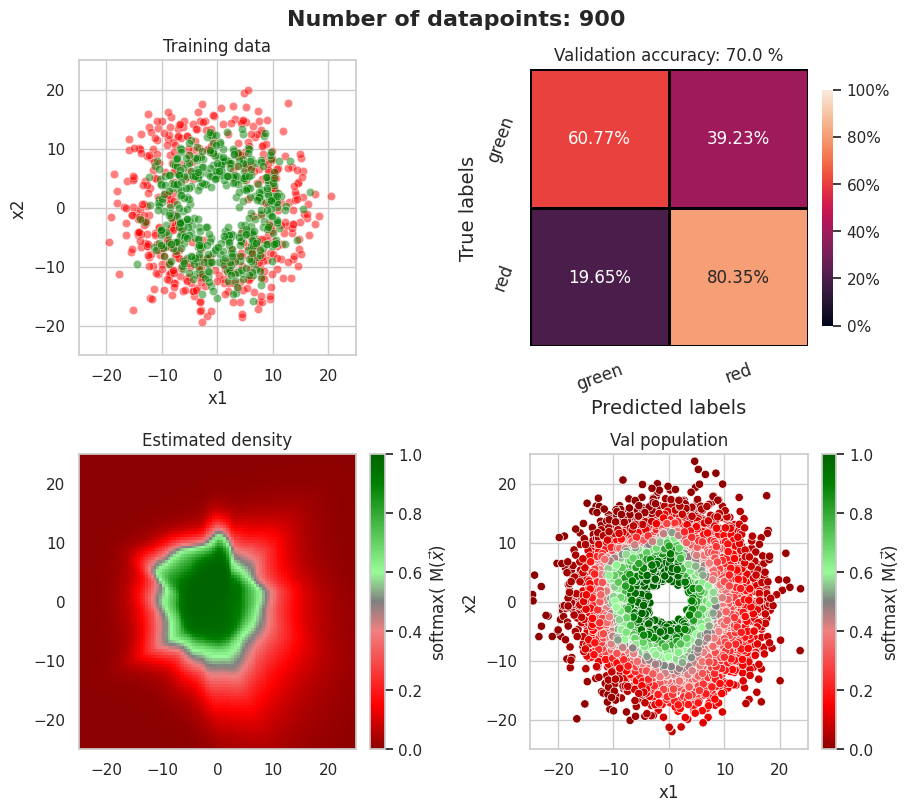

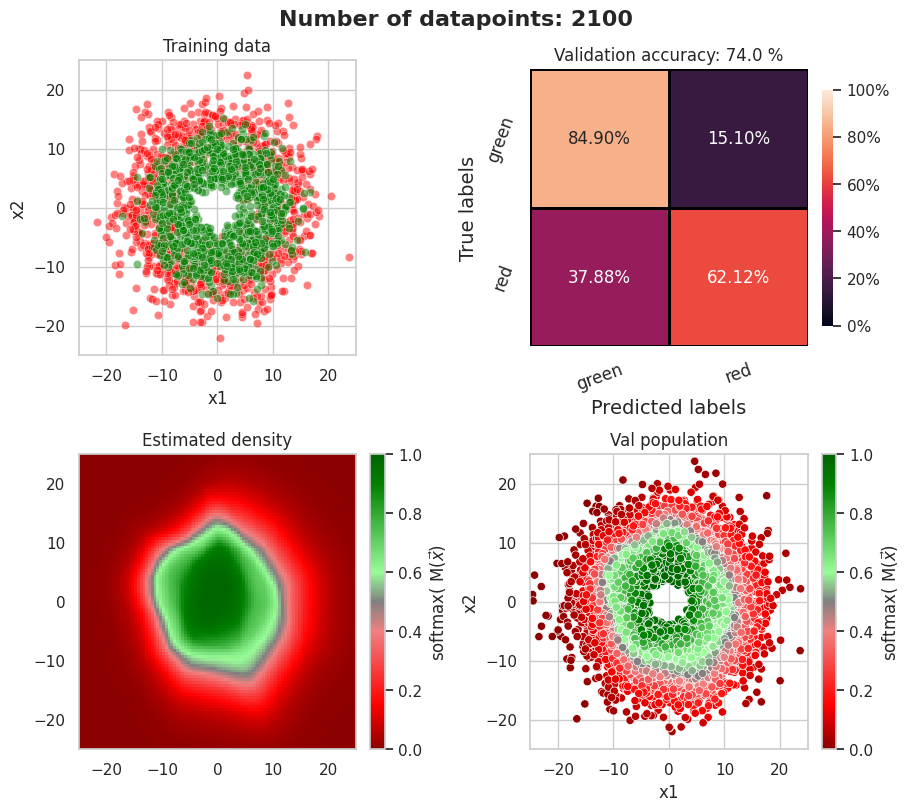

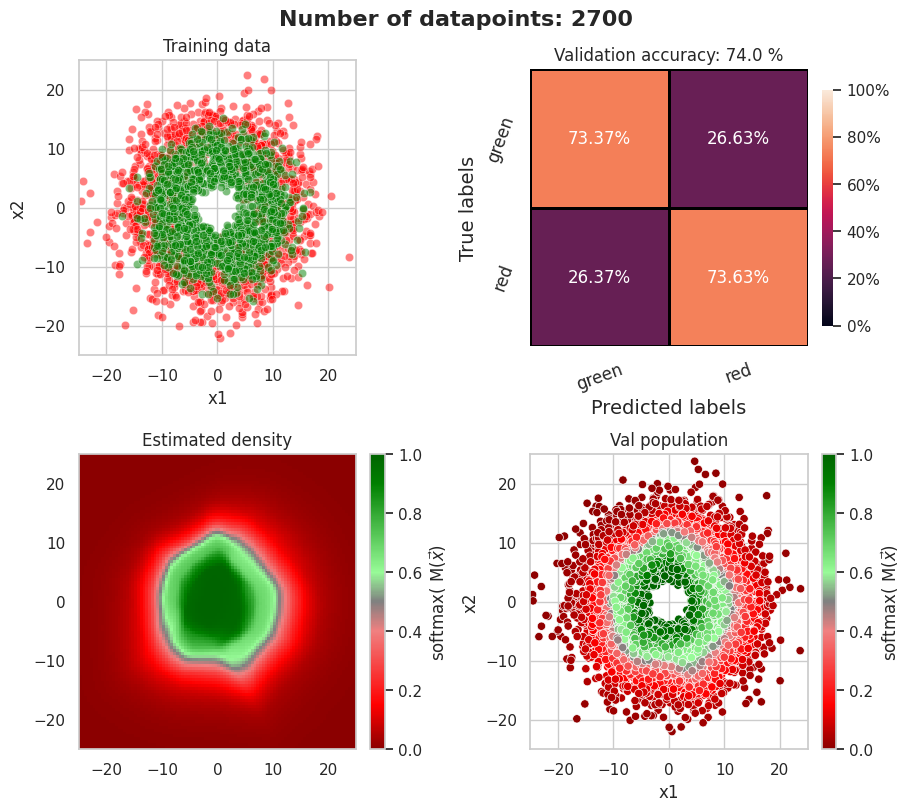

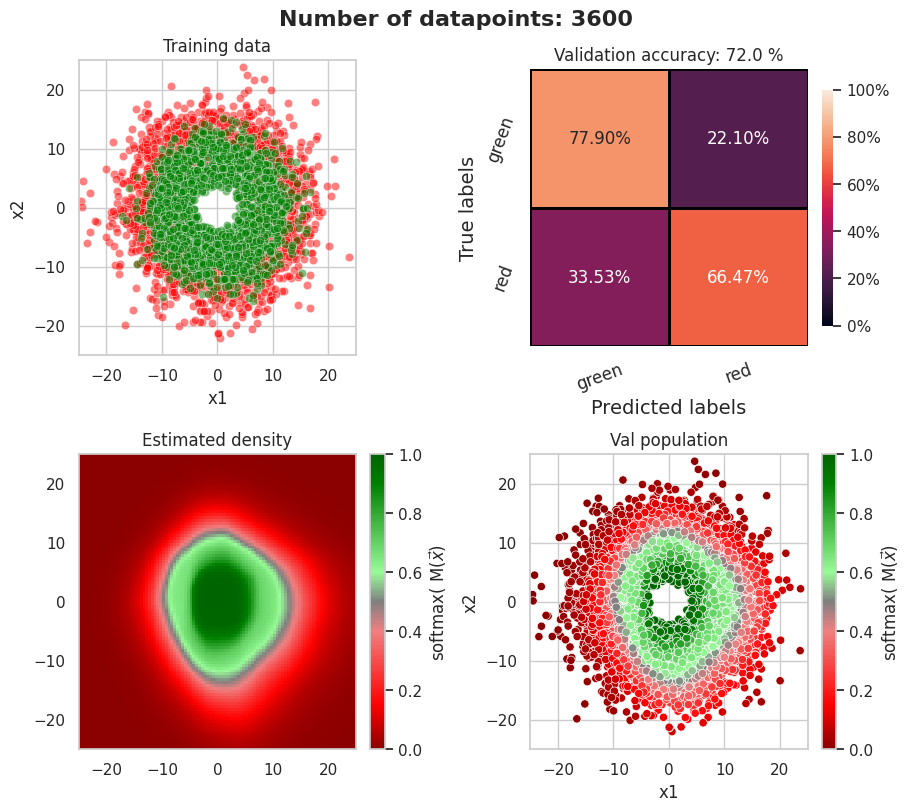

In [110]:

# Plot animation

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8), layout="constrained")
    df_val = process_data(cal_datafiles[i])
    df_test = process_data(grid_datafiles[i], test=True)
    accuracy = accuracy_score(df_val["Truth"], df_val["Predicted_color"], normalize=True)
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0])
    axs[0][1] = plot_conf_matrix(df_val, "Predicted_color", accuracy, ["green", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, "Confidence", axs[1][0], "Estimated density", grid=True)
    axs[1][1] = plot_results(df_val, "Confidence", axs[1][1], "Val population", error=False)
    #axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Error test points", grid=True)
    #axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Error train data")
    
    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])
    #hue_norm_error = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_error, cmap="viridis"), label=r'Error', ax=axs[2][0])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "green"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")
    #lt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

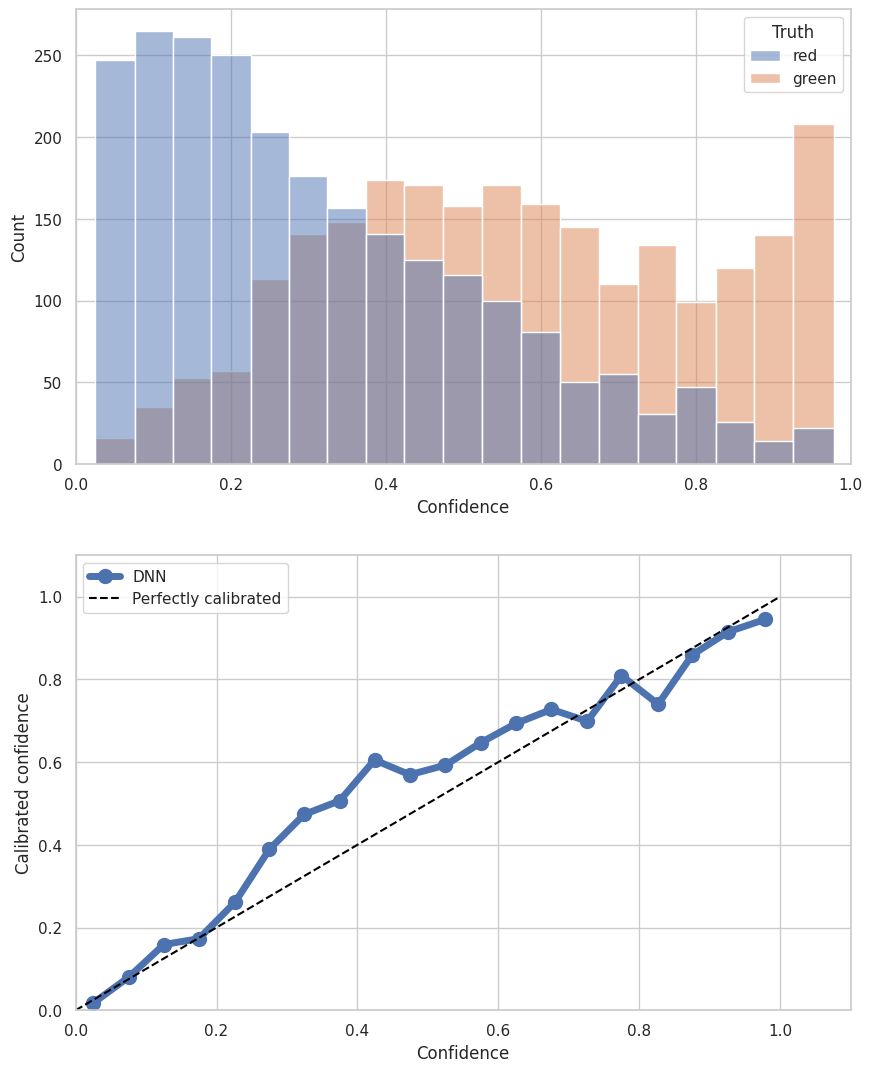

In [111]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
cal_data = process_data(cal_datafiles[0])

prob_cal, prob_pred = calibration_curve(cal_data["Truth_int"], cal_data["Confidence"], n_bins=20, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(cal_data, x="Confidence", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()

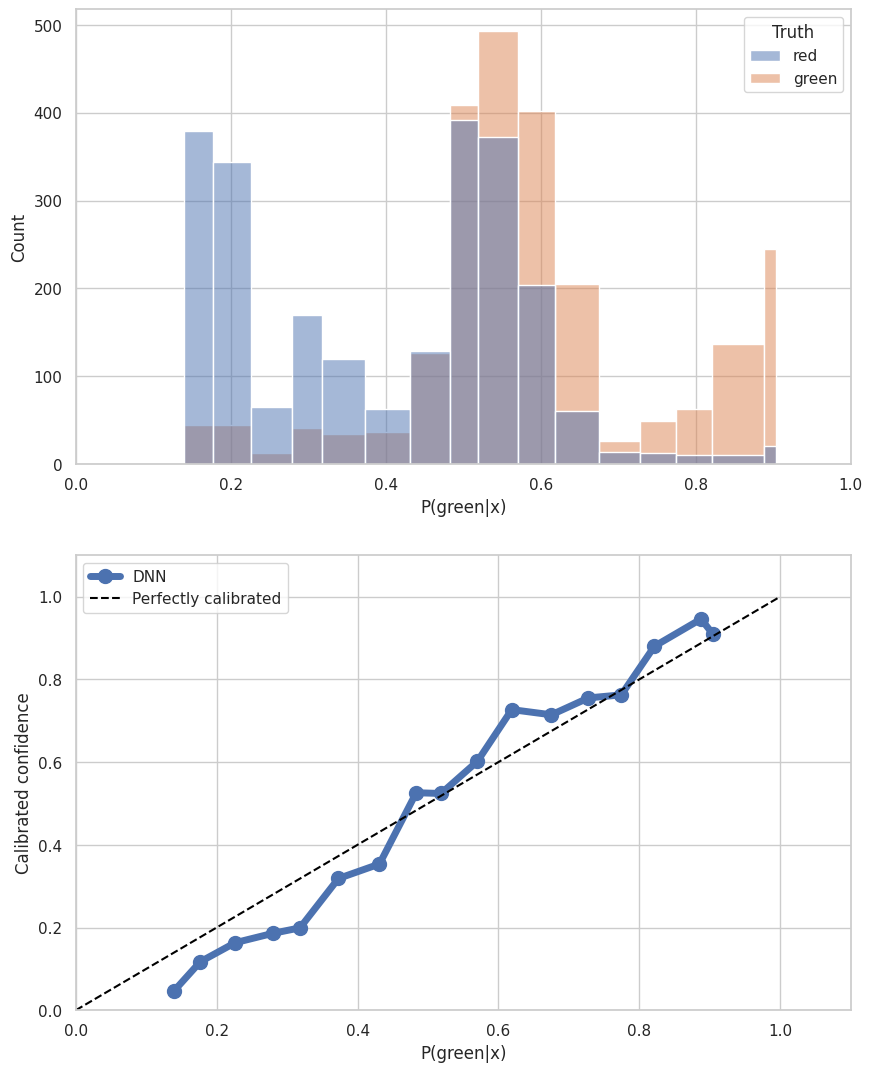

In [112]:

prob_cal, prob_pred = calibration_curve(cal_data["Truth_int"], cal_data["P(green|x)"], n_bins=20, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(cal_data, x="P(green|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("P(green|x)")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()

Text(0, 0.5, 'Probability')

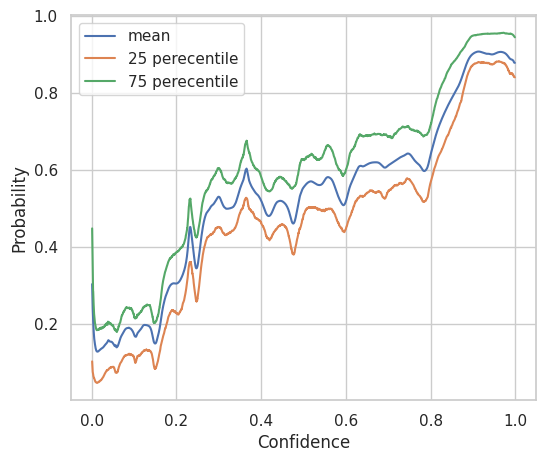

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sn.lineplot(cal_data, x="Confidence", y="green", label="mean", ax=ax)
sn.lineplot(cal_data, x="Confidence", y="quantile25_green", label = "25 perecentile", ax=ax)
sn.lineplot(cal_data, x="Confidence", y="quantile75_green", label = "75 perecentile", ax=ax)
ax.legend()
ax.set_ylabel("Probability")

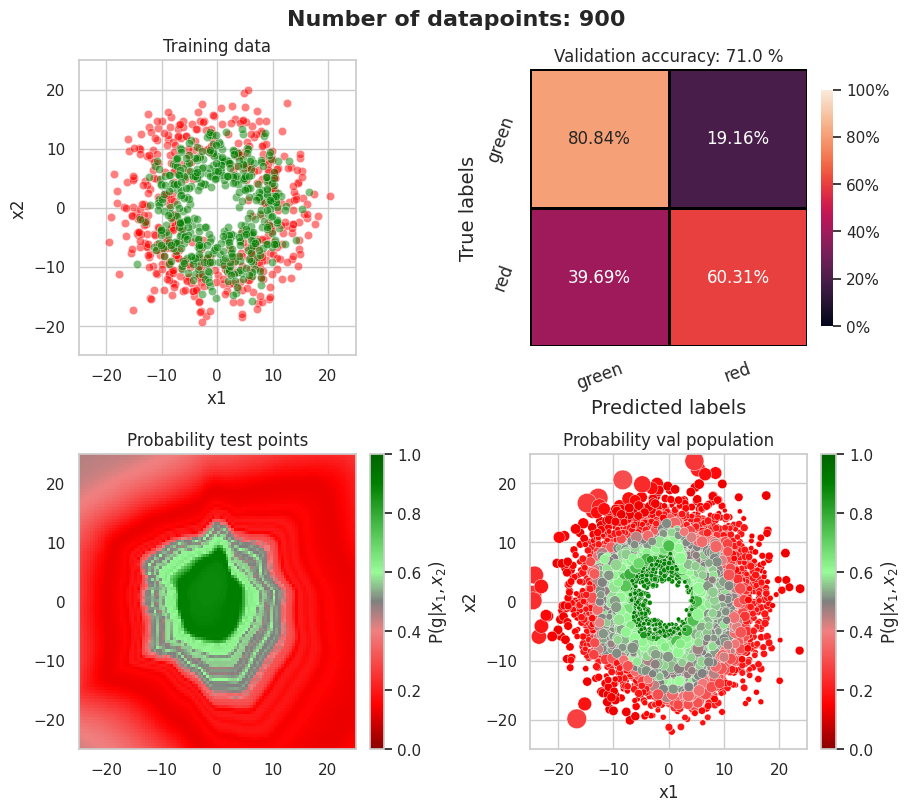

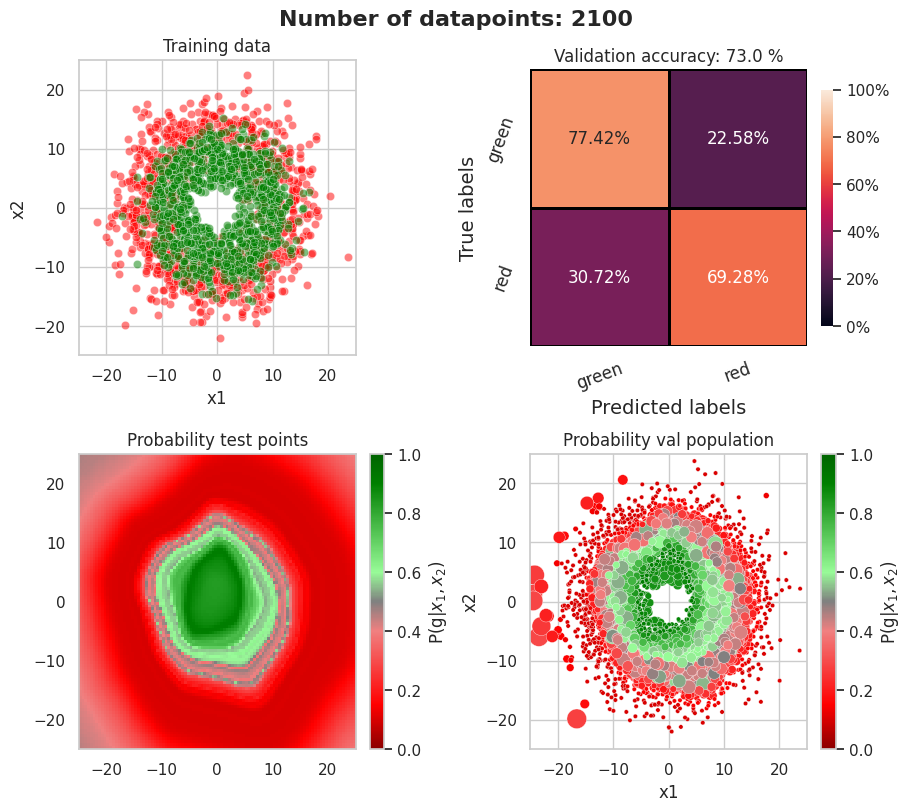

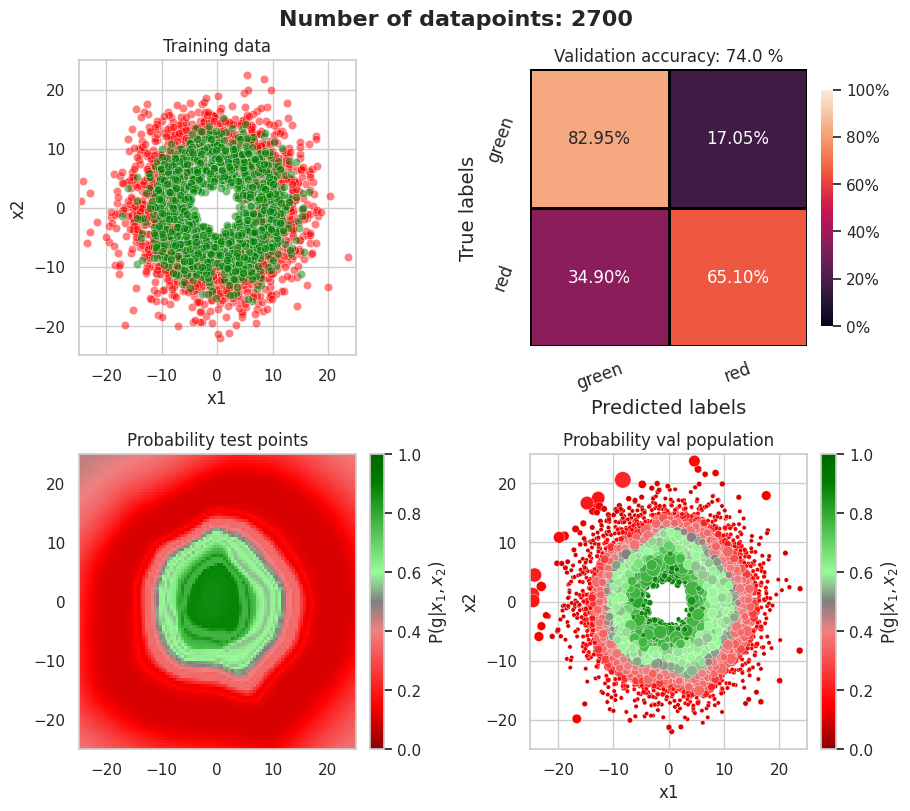

In [114]:

# Plot animation

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8), layout="constrained")
    df_val = process_data(cal_datafiles[i], test=False)
    df_test = process_data(grid_datafiles[i], test=True)
    accuracy = accuracy_score(df_val["Truth"], df_val["Inferred_color"], normalize=True)
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0])
    axs[0][1] = plot_conf_matrix(df_val, "Inferred_color", accuracy, ["green", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, "P(green|x)", axs[1][0], "Probability test points", grid=True)
    axs[1][1] = plot_results(df_val, "P(green|x)", axs[1][1], "Probability val population", error=True)
    #axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Error test points", grid=True)
    #axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Error train data")
    
    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][1])
    #hue_norm_error = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_error, cmap="viridis"), label=r'Error', ax=axs[2][0])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "green"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")
    #lt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    